# Imports

In [2]:
import time
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import pytorch_ssim  # For SSIM calculation
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import numpy as np

from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim

c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preproccessing

##### DIV2K dataset is used

In [ ]:
# This is run only once
from PIL import Image
import os

def center_crop_images(dataset_path):
    # List all image files in the dataset
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Initialize variables to store the minimum width and height
    min_width = float('inf')
    min_height = float('inf')
    
    # Find the smallest image dimensions
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
    
    # Center crop all images to the size of the smallest image
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            # Calculate the cropping box (center crop)
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height
            
            # Crop and save the image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(os.path.join(dataset_path, f"cropped_{image_file}"))

# Crops all images in the dataset and saving them, original images were deleted manually by me
dataset_path = "./DIV2K_train_HR_Cropped"
center_crop_images(dataset_path)

## Synthetic LR Image Creation

In [7]:
class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None, scale=2):
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(path).convert('RGB')  # Change from 'L' to 'RGB' for color images

        hr = img
        lr = hr.resize((hr.width // self.scale, hr.height // self.scale), Image.BICUBIC)
        lr = lr.resize((hr.width, hr.height), Image.BICUBIC)

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)

        return lr, hr

In [18]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./DIV2K_train_HR_Cropped", transform=transform, scale=2)

    # Split sizes (e.g., 90% train, 10% val)
train_size = int(0.9 * len(full_dataset))  # 720
val_size = len(full_dataset) - train_size  # 80

    # Split the dataset randomly
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1)
    

torch.Size([3, 648, 1116])


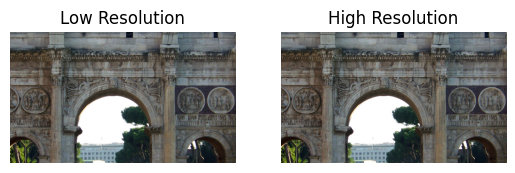

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0000,  0.0039,  0.0000,  ..., -0.0314,  0.0157,  0.0157],
          [-0.0039,  0.0000,  0.0000,  ...,  0.0196,  0.0275, -0.0157],
          [ 0.0039, -0.0039,  0.0000,  ..., -0.0039,  0.0118, -0.0392],
          ...,
          [-0.0510,  0.0824,  0.0745,  ...,  0.0000,  0.0000,  0.0039],
          [-0.1686, -0.0824, -0.0824,  ..., -0.0078,  0.0039,  0.0118],
          [ 0.1255,  0.1569,  0.1255,  ...,  0.0000, -0.0078, -0.0118]],

         [[-0.0039, -0.0039,  0.0039,  ..., -0.0392,  0.0118,  0.0157],
          [ 0.0000, -0.0039,  0.0078,  ...,  0.0235,  0.0275, -0.0157],
          [ 0.0118,  0.0000,  0.0039,  ...,  0.0039,  0.0157, -0.0392],
          ...,
          [-0.0863,  0.0549,  0.0706,  ...,  0.0000,  0.0039,  0.0039],
          [-0.1255, -0.0431, -0.0392,  ..., -0.0039,  0.0078,  0.0078],
          [ 0.0902,  0.1216,  0.1059,  ...,  0.0000, -0.0078, -0.0118]],

         [[-0.0039,  0.0000, -0.0078,  ...

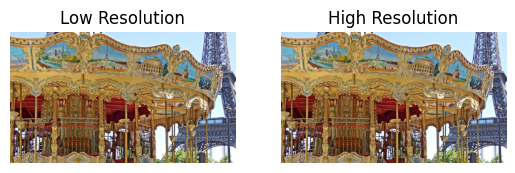

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0000,  0.0000,  0.0078,  ..., -0.0078, -0.0039,  0.0000],
          [ 0.0000,  0.0039,  0.0078,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0039,  0.0000, -0.0039,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0275, -0.0118, -0.0392,  ...,  0.0039,  0.0078, -0.0078],
          [ 0.0431, -0.0118, -0.0588,  ...,  0.0078,  0.0314,  0.0196],
          [ 0.0549, -0.0118, -0.0588,  ...,  0.0118,  0.0353, -0.1294]],

         [[ 0.0000,  0.0000,  0.0039,  ..., -0.0039, -0.0039,  0.0000],
          [ 0.0000, -0.0039,  0.0000,  ...,  0.0039,  0.0000,  0.0000],
          [-0.0039, -0.0039, -0.0078,  ..., -0.0039,  0.0000,  0.0000],
          ...,
          [ 0.0314,  0.0000, -0.0431,  ...,  0.0039,  0.0078,  0.0039],
          [ 0.0314,  0.0000, -0.0549,  ...,  0.0078,  0.0314,  0.0235],
          [ 0.0431,  0.0000, -0.0549,  ...,  0.0118,  0.0353, -0.1333]],

         [[ 0.0000,  0.0000,  0.0000,  ...

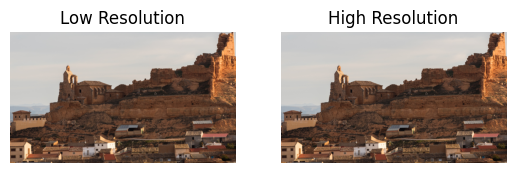

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0039,  0.0000,  0.0000],
          [ 0.0000, -0.0039,  0.0000,  ...,  0.0000, -0.0039,  0.0039],
          ...,
          [-0.0902, -0.0510,  0.1255,  ..., -0.0588,  0.2078, -0.0235],
          [-0.2039,  0.0078,  0.1765,  ...,  0.0157,  0.0431,  0.0510],
          [-0.1333,  0.1216,  0.1059,  ..., -0.1176, -0.1137, -0.0078]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0039,  0.0000,  0.0000],
          [ 0.0000, -0.0039,  0.0000,  ...,  0.0000, -0.0039,  0.0039],
          ...,
          [-0.0627, -0.0431,  0.1020,  ..., -0.0510,  0.2118,  0.0039],
          [-0.1608,  0.0078,  0.1451,  ...,  0.0235,  0.0392,  0.0471],
          [-0.1216,  0.1020,  0.0863,  ..., -0.1137, -0.1098, -0.0118]],

         [[ 0.0000,  0.0000,  0.0000,  ...

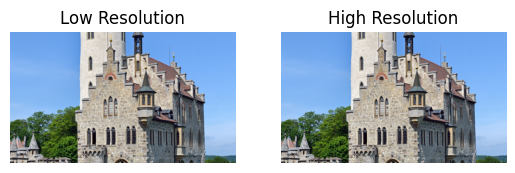

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0039,  0.0000, -0.0039,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0039,  ...,  0.0039,  0.0000,  0.0000],
          [ 0.0039,  0.0039,  0.0039,  ..., -0.0039,  0.0000,  0.0000],
          ...,
          [-0.0353, -0.0196, -0.0392,  ..., -0.0392,  0.0118,  0.0863],
          [-0.1451, -0.1412, -0.1059,  ...,  0.0000,  0.0902, -0.0353],
          [ 0.1922,  0.1373,  0.2745,  ..., -0.0118,  0.0667, -0.0824]],

         [[ 0.0000,  0.0000, -0.0039,  ..., -0.0039,  0.0000,  0.0000],
          [ 0.0000, -0.0039,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.0275, -0.0078, -0.0353,  ..., -0.0353,  0.0118,  0.0980],
          [-0.1529, -0.1373, -0.1059,  ...,  0.0000,  0.0902, -0.0235],
          [ 0.1882,  0.1373,  0.2784,  ..., -0.0196,  0.0549, -0.0902]],

         [[ 0.0000,  0.0000, -0.0039,  ...

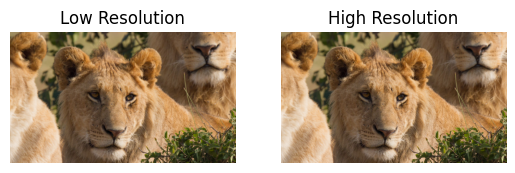

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0000, -0.0078,  0.0000,  ..., -0.0078, -0.0039,  0.0039],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0039,  0.0000,  0.0078],
          [ 0.0078,  0.0000, -0.0039,  ...,  0.0000,  0.0039,  0.0000],
          ...,
          [ 0.0118, -0.0078,  0.0000,  ..., -0.0118, -0.0275,  0.0235],
          [ 0.0118, -0.0157, -0.0118,  ...,  0.0039, -0.0196,  0.0000],
          [ 0.0039, -0.0039, -0.0078,  ...,  0.0078,  0.0039,  0.0196]],

         [[ 0.0000, -0.0078,  0.0000,  ..., -0.0039, -0.0039,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0000],
          [ 0.0078,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0039],
          ...,
          [ 0.0157, -0.0118, -0.0078,  ..., -0.0196, -0.0431,  0.0471],
          [ 0.0078, -0.0157, -0.0157,  ...,  0.0000, -0.0353,  0.0078],
          [ 0.0118, -0.0039, -0.0039,  ...,  0.0039, -0.0078,  0.0235]],

         [[ 0.0000, -0.0078,  0.0000,  ...

In [19]:
print(val_loader.dataset[0][0].shape)  # Check the shape of the first batch
# show images in val_loader
for i, (lr, hr) in enumerate(val_loader):
    if i == 5:
        break
    plt.subplot(1, 2, 1)
    plt.imshow(lr[0].permute(1, 2, 0).numpy())
    plt.title("Low Resolution")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hr[0].permute(1, 2, 0).numpy())
    plt.title("High Resolution")
    plt.axis('off')
    plt.show()
    difference = hr - lr
    print("Difference shape:", difference.shape) # if the difference is not 0, then the images are different
    print("Difference:", difference)  # Check the difference between HR and LR images

##### The difference between the images are very subtle because the scale is x2 but the images are indeed different. As shown in the results saved from the inference cell (in Results and for comparison folders), cv2 shows the difference between LR and HR more accurately. 

# Model

In [20]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=9, padding=4),  # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=1),           # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


#### As part of the hyperparameter tuning, I Increased the number of filters to 128 to see if this will allow the model to pick up more finegrained details.

# Evaluation Scoring Functions

In [21]:
import torch.nn as nn

class LossMSE(nn.Module):
    def __init__(self):
        super(LossMSE, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        return self.mse_loss(output, target)


In [22]:
def psnr(target, output, data_range=1.0):
    mse = np.mean((target - output) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(data_range / np.sqrt(mse))

# Evaluation Function

In [23]:
def evaluate(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img).clamp(0.0, 1.0)
            
            psnr_val = psnr(hr_img.squeeze().cpu().numpy(), sr_img.squeeze().cpu().numpy())
            ssim_val = compute_ssim(sr_img, hr_img, data_range=1.0).item()
            
            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    return (
        sum(psnr_scores) / len(psnr_scores),
        sum(ssim_scores) / len(ssim_scores)
    )

## Plotting Graphs

In [24]:
def plot_learning_curve(epoch_losses, epoch_val_losses, epoch_psnrs, epoch_ssims):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(epoch_val_losses) + 1), epoch_val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_psnrs) + 1), epoch_psnrs, label='Validation PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Validation PSNR Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if epoch_ssims is not None:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(epoch_ssims) + 1), epoch_ssims, label='Validation SSIM', color='purple')
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.title('Validation SSIM Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("ssim_curve.png")
        plt.show()

# Train Function

In [25]:
def train(model, train_dataloader, val_dataloader, epochs=5, lr=1e-4, log_dir="runs/SRCNNx2ht"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = LossMSE()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    writer = SummaryWriter(log_dir)

    epoch_losses = []
    epoch_val_losses = []
    epoch_psnrs = []
    epoch_ssims = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for lr_img, hr_img in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            output = model(lr_img)
            loss = criterion(output, hr_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_dataloader)
        epoch_losses.append(avg_train_loss)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Evaluate PSNR and SSIM
        val_psnr, val_ssim = evaluate(model, val_dataloader)
        epoch_psnrs.append(val_psnr)
        epoch_ssims.append(val_ssim)
        writer.add_scalar("PSNR/Val", val_psnr, epoch)
        writer.add_scalar("SSIM/Val", val_ssim, epoch)

        # Compute validation loss
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                output = model(lr_img)
                loss = criterion(output, hr_img)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        epoch_val_losses.append(avg_val_loss)
        writer.add_scalar("Loss/Val", avg_val_loss, epoch)

        # Log sample images from validation
        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img = lr_img.to(device)
                output = model(lr_img).clamp(0.0, 1.0)
                writer.add_images("Input/LR", lr_img, epoch)
                writer.add_images("Output/SR", output, epoch)
                writer.add_images("Target/HR", hr_img.to(device), epoch)
                break  # Log only first batch

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    writer.close()
    plot_learning_curve(epoch_losses, epoch_val_losses, epoch_psnrs, epoch_ssims)
    return model


#### Another hyperparameter tuning I did was change the optimizer from Adam to AdamW with weight decay 1e-4. 

# Training The Model


Training SRCNN after hyperparameter tuning...


Epoch 1: 100%|██████████| 90/90 [04:51<00:00,  3.24s/it]


Epoch 1: Train Loss = 0.0346, Val Loss = 0.0071, PSNR = 22.33, SSIM = 0.6265


Epoch 2: 100%|██████████| 90/90 [04:55<00:00,  3.28s/it]


Epoch 2: Train Loss = 0.0057, Val Loss = 0.0037, PSNR = 25.32, SSIM = 0.7509


Epoch 3: 100%|██████████| 90/90 [04:57<00:00,  3.30s/it]


Epoch 3: Train Loss = 0.0038, Val Loss = 0.0031, PSNR = 26.29, SSIM = 0.7873


Epoch 4: 100%|██████████| 90/90 [04:37<00:00,  3.08s/it]


Epoch 4: Train Loss = 0.0033, Val Loss = 0.0027, PSNR = 27.07, SSIM = 0.8102


Epoch 5: 100%|██████████| 90/90 [04:45<00:00,  3.18s/it]


Epoch 5: Train Loss = 0.0029, Val Loss = 0.0023, PSNR = 27.74, SSIM = 0.8282


Epoch 6: 100%|██████████| 90/90 [04:29<00:00,  3.00s/it]


Epoch 6: Train Loss = 0.0026, Val Loss = 0.0022, PSNR = 27.96, SSIM = 0.8390


Epoch 7: 100%|██████████| 90/90 [04:29<00:00,  3.00s/it]


Epoch 7: Train Loss = 0.0024, Val Loss = 0.0020, PSNR = 28.48, SSIM = 0.8460


Epoch 8: 100%|██████████| 90/90 [04:47<00:00,  3.20s/it]


Epoch 8: Train Loss = 0.0023, Val Loss = 0.0019, PSNR = 28.84, SSIM = 0.8518


Epoch 9: 100%|██████████| 90/90 [04:48<00:00,  3.20s/it]


Epoch 9: Train Loss = 0.0022, Val Loss = 0.0019, PSNR = 29.04, SSIM = 0.8564


Epoch 10: 100%|██████████| 90/90 [04:45<00:00,  3.17s/it]


Epoch 10: Train Loss = 0.0021, Val Loss = 0.0018, PSNR = 29.19, SSIM = 0.8605


Epoch 11: 100%|██████████| 90/90 [04:47<00:00,  3.19s/it]


Epoch 11: Train Loss = 0.0021, Val Loss = 0.0018, PSNR = 29.15, SSIM = 0.8637


Epoch 12: 100%|██████████| 90/90 [05:22<00:00,  3.58s/it]


Epoch 12: Train Loss = 0.0021, Val Loss = 0.0017, PSNR = 29.39, SSIM = 0.8660


Epoch 13: 100%|██████████| 90/90 [04:42<00:00,  3.14s/it]


Epoch 13: Train Loss = 0.0020, Val Loss = 0.0017, PSNR = 29.57, SSIM = 0.8688


Epoch 14: 100%|██████████| 90/90 [04:23<00:00,  2.92s/it]


Epoch 14: Train Loss = 0.0020, Val Loss = 0.0017, PSNR = 29.59, SSIM = 0.8712


Epoch 15: 100%|██████████| 90/90 [04:23<00:00,  2.92s/it]


Epoch 15: Train Loss = 0.0020, Val Loss = 0.0016, PSNR = 29.75, SSIM = 0.8731


Epoch 16: 100%|██████████| 90/90 [04:32<00:00,  3.03s/it]


Epoch 16: Train Loss = 0.0019, Val Loss = 0.0016, PSNR = 29.84, SSIM = 0.8749


Epoch 17: 100%|██████████| 90/90 [04:40<00:00,  3.12s/it]


Epoch 17: Train Loss = 0.0019, Val Loss = 0.0016, PSNR = 29.91, SSIM = 0.8764


Epoch 18: 100%|██████████| 90/90 [04:42<00:00,  3.14s/it]


Epoch 18: Train Loss = 0.0019, Val Loss = 0.0016, PSNR = 29.82, SSIM = 0.8776


Epoch 19: 100%|██████████| 90/90 [04:42<00:00,  3.13s/it]


Epoch 19: Train Loss = 0.0019, Val Loss = 0.0016, PSNR = 29.99, SSIM = 0.8792


Epoch 20: 100%|██████████| 90/90 [04:41<00:00,  3.12s/it]


Epoch 20: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.07, SSIM = 0.8808


Epoch 21: 100%|██████████| 90/90 [04:39<00:00,  3.10s/it]


Epoch 21: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.03, SSIM = 0.8819


Epoch 22: 100%|██████████| 90/90 [04:37<00:00,  3.08s/it]


Epoch 22: Train Loss = 0.0019, Val Loss = 0.0015, PSNR = 30.12, SSIM = 0.8835


Epoch 23: 100%|██████████| 90/90 [05:12<00:00,  3.47s/it]


Epoch 23: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.17, SSIM = 0.8846


Epoch 24: 100%|██████████| 90/90 [06:27<00:00,  4.31s/it]


Epoch 24: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.27, SSIM = 0.8858


Epoch 25: 100%|██████████| 90/90 [07:04<00:00,  4.72s/it]


Epoch 25: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.33, SSIM = 0.8867


Epoch 26: 100%|██████████| 90/90 [09:15<00:00,  6.17s/it]


Epoch 26: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 29.74, SSIM = 0.8871


Epoch 27: 100%|██████████| 90/90 [07:13<00:00,  4.82s/it]


Epoch 27: Train Loss = 0.0018, Val Loss = 0.0015, PSNR = 30.13, SSIM = 0.8881


Epoch 28: 100%|██████████| 90/90 [06:58<00:00,  4.65s/it]


Epoch 28: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.44, SSIM = 0.8891


Epoch 29: 100%|██████████| 90/90 [05:11<00:00,  3.46s/it]


Epoch 29: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.47, SSIM = 0.8898


Epoch 30: 100%|██████████| 90/90 [05:06<00:00,  3.40s/it]


Epoch 30: Train Loss = 0.0018, Val Loss = 0.0014, PSNR = 30.41, SSIM = 0.8902


Epoch 31: 100%|██████████| 90/90 [05:11<00:00,  3.46s/it]


Epoch 31: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.49, SSIM = 0.8910


Epoch 32: 100%|██████████| 90/90 [05:02<00:00,  3.36s/it]


Epoch 32: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.55, SSIM = 0.8917


Epoch 33: 100%|██████████| 90/90 [05:01<00:00,  3.35s/it]


Epoch 33: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.57, SSIM = 0.8921


Epoch 34: 100%|██████████| 90/90 [04:55<00:00,  3.28s/it]


Epoch 34: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.59, SSIM = 0.8930


Epoch 35: 100%|██████████| 90/90 [04:50<00:00,  3.23s/it]


Epoch 35: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.21, SSIM = 0.8926


Epoch 36: 100%|██████████| 90/90 [04:52<00:00,  3.25s/it]


Epoch 36: Train Loss = 0.0018, Val Loss = 0.0014, PSNR = 30.64, SSIM = 0.8938


Epoch 37: 100%|██████████| 90/90 [05:05<00:00,  3.40s/it]


Epoch 37: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.67, SSIM = 0.8941


Epoch 38: 100%|██████████| 90/90 [05:11<00:00,  3.46s/it]


Epoch 38: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.66, SSIM = 0.8943


Epoch 39: 100%|██████████| 90/90 [04:52<00:00,  3.25s/it]


Epoch 39: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.42, SSIM = 0.8951


Epoch 40: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it]


Epoch 40: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.69, SSIM = 0.8954


Epoch 41: 100%|██████████| 90/90 [04:24<00:00,  2.94s/it]


Epoch 41: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.72, SSIM = 0.8957


Epoch 42: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it]


Epoch 42: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.76, SSIM = 0.8961


Epoch 43: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 43: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.21, SSIM = 0.8957


Epoch 44: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 44: Train Loss = 0.0019, Val Loss = 0.0018, PSNR = 28.55, SSIM = 0.8928


Epoch 45: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 45: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.80, SSIM = 0.8967


Epoch 46: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 46: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.83, SSIM = 0.8972


Epoch 47: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 47: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.84, SSIM = 0.8972


Epoch 48: 100%|██████████| 90/90 [04:35<00:00,  3.06s/it]


Epoch 48: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.85, SSIM = 0.8976


Epoch 49: 100%|██████████| 90/90 [04:36<00:00,  3.07s/it]


Epoch 49: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.87, SSIM = 0.8978


Epoch 50: 100%|██████████| 90/90 [04:41<00:00,  3.12s/it]


Epoch 50: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.82, SSIM = 0.8980


Epoch 51: 100%|██████████| 90/90 [06:01<00:00,  4.02s/it]


Epoch 51: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.85, SSIM = 0.8982


Epoch 52: 100%|██████████| 90/90 [06:50<00:00,  4.56s/it]


Epoch 52: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.90, SSIM = 0.8985


Epoch 53: 100%|██████████| 90/90 [06:53<00:00,  4.59s/it]


Epoch 53: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.92, SSIM = 0.8989


Epoch 54: 100%|██████████| 90/90 [07:30<00:00,  5.01s/it]


Epoch 54: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.92, SSIM = 0.8988


Epoch 55: 100%|██████████| 90/90 [06:39<00:00,  4.44s/it]


Epoch 55: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.93, SSIM = 0.8992


Epoch 56: 100%|██████████| 90/90 [06:58<00:00,  4.65s/it]


Epoch 56: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.96, SSIM = 0.8995


Epoch 57: 100%|██████████| 90/90 [05:28<00:00,  3.65s/it]


Epoch 57: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.77, SSIM = 0.8998


Epoch 58: 100%|██████████| 90/90 [04:31<00:00,  3.01s/it]


Epoch 58: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.72, SSIM = 0.8998


Epoch 59: 100%|██████████| 90/90 [05:02<00:00,  3.36s/it]


Epoch 59: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.95, SSIM = 0.8998


Epoch 60: 100%|██████████| 90/90 [04:52<00:00,  3.25s/it]


Epoch 60: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.00, SSIM = 0.9001


Epoch 61: 100%|██████████| 90/90 [04:26<00:00,  2.96s/it]


Epoch 61: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.98, SSIM = 0.9002


Epoch 62: 100%|██████████| 90/90 [05:08<00:00,  3.42s/it]


Epoch 62: Train Loss = 0.0016, Val Loss = 0.0015, PSNR = 29.80, SSIM = 0.8993


Epoch 63: 100%|██████████| 90/90 [04:53<00:00,  3.27s/it]


Epoch 63: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.99, SSIM = 0.9008


Epoch 64: 100%|██████████| 90/90 [04:54<00:00,  3.28s/it]


Epoch 64: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.36, SSIM = 0.8995


Epoch 65: 100%|██████████| 90/90 [04:58<00:00,  3.31s/it]


Epoch 65: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.02, SSIM = 0.9010


Epoch 66: 100%|██████████| 90/90 [04:54<00:00,  3.28s/it]


Epoch 66: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.83, SSIM = 0.9007


Epoch 67: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it]


Epoch 67: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.03, SSIM = 0.9012


Epoch 68: 100%|██████████| 90/90 [04:22<00:00,  2.92s/it]


Epoch 68: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.06, SSIM = 0.9013


Epoch 69: 100%|██████████| 90/90 [04:43<00:00,  3.15s/it]


Epoch 69: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.01, SSIM = 0.9012


Epoch 70: 100%|██████████| 90/90 [05:08<00:00,  3.43s/it]


Epoch 70: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.54, SSIM = 0.9012


Epoch 71: 100%|██████████| 90/90 [05:04<00:00,  3.39s/it]


Epoch 71: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.08, SSIM = 0.9018


Epoch 72: 100%|██████████| 90/90 [04:59<00:00,  3.33s/it]


Epoch 72: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.09, SSIM = 0.9020


Epoch 73: 100%|██████████| 90/90 [04:58<00:00,  3.32s/it]


Epoch 73: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.09, SSIM = 0.9021


Epoch 74: 100%|██████████| 90/90 [05:03<00:00,  3.37s/it]


Epoch 74: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.92, SSIM = 0.9019


Epoch 75: 100%|██████████| 90/90 [04:59<00:00,  3.33s/it]


Epoch 75: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.12, SSIM = 0.9023


Epoch 76: 100%|██████████| 90/90 [04:48<00:00,  3.21s/it]


Epoch 76: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.75, SSIM = 0.9021


Epoch 77: 100%|██████████| 90/90 [04:46<00:00,  3.18s/it]


Epoch 77: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.09, SSIM = 0.9024


Epoch 78: 100%|██████████| 90/90 [04:41<00:00,  3.13s/it]


Epoch 78: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.94, SSIM = 0.9024


Epoch 79: 100%|██████████| 90/90 [04:43<00:00,  3.15s/it]


Epoch 79: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.08, SSIM = 0.9026


Epoch 80: 100%|██████████| 90/90 [04:29<00:00,  2.99s/it]


Epoch 80: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.15, SSIM = 0.9028


Epoch 81: 100%|██████████| 90/90 [04:27<00:00,  2.97s/it]


Epoch 81: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.04, SSIM = 0.9028


Epoch 82: 100%|██████████| 90/90 [05:00<00:00,  3.34s/it]


Epoch 82: Train Loss = 0.0017, Val Loss = 0.0013, PSNR = 31.09, SSIM = 0.9028


Epoch 83: 100%|██████████| 90/90 [05:04<00:00,  3.38s/it]


Epoch 83: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.17, SSIM = 0.9031


Epoch 84: 100%|██████████| 90/90 [04:58<00:00,  3.32s/it]


Epoch 84: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.14, SSIM = 0.9032


Epoch 85: 100%|██████████| 90/90 [05:04<00:00,  3.39s/it]


Epoch 85: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.17, SSIM = 0.9033


Epoch 86: 100%|██████████| 90/90 [05:03<00:00,  3.37s/it]


Epoch 86: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.18, SSIM = 0.9033


Epoch 87: 100%|██████████| 90/90 [05:05<00:00,  3.39s/it]


Epoch 87: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.18, SSIM = 0.9034


Epoch 88: 100%|██████████| 90/90 [05:06<00:00,  3.41s/it]


Epoch 88: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.96, SSIM = 0.9034


Epoch 89: 100%|██████████| 90/90 [05:05<00:00,  3.40s/it]


Epoch 89: Train Loss = 0.0016, Val Loss = 0.0016, PSNR = 29.20, SSIM = 0.8999


Epoch 90: 100%|██████████| 90/90 [05:09<00:00,  3.44s/it]


Epoch 90: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 31.20, SSIM = 0.9038


Epoch 91: 100%|██████████| 90/90 [05:07<00:00,  3.42s/it]


Epoch 91: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.21, SSIM = 0.9038


Epoch 92: 100%|██████████| 90/90 [05:09<00:00,  3.44s/it]


Epoch 92: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.22, SSIM = 0.9039


Epoch 93: 100%|██████████| 90/90 [05:14<00:00,  3.50s/it]


Epoch 93: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.23, SSIM = 0.9040


Epoch 94: 100%|██████████| 90/90 [07:01<00:00,  4.69s/it]


Epoch 94: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.23, SSIM = 0.9041


Epoch 95: 100%|██████████| 90/90 [06:53<00:00,  4.59s/it]


Epoch 95: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.24, SSIM = 0.9041


Epoch 96: 100%|██████████| 90/90 [07:35<00:00,  5.07s/it]


Epoch 96: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.23, SSIM = 0.9041


Epoch 97: 100%|██████████| 90/90 [06:56<00:00,  4.63s/it]


Epoch 97: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.23, SSIM = 0.9045


Epoch 98: 100%|██████████| 90/90 [06:35<00:00,  4.39s/it]


Epoch 98: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.05, SSIM = 0.9045


Epoch 99: 100%|██████████| 90/90 [06:32<00:00,  4.36s/it]


Epoch 99: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.16, SSIM = 0.9043


Epoch 100: 100%|██████████| 90/90 [06:41<00:00,  4.46s/it]


Epoch 100: Train Loss = 0.0015, Val Loss = 0.0012, PSNR = 31.28, SSIM = 0.9048


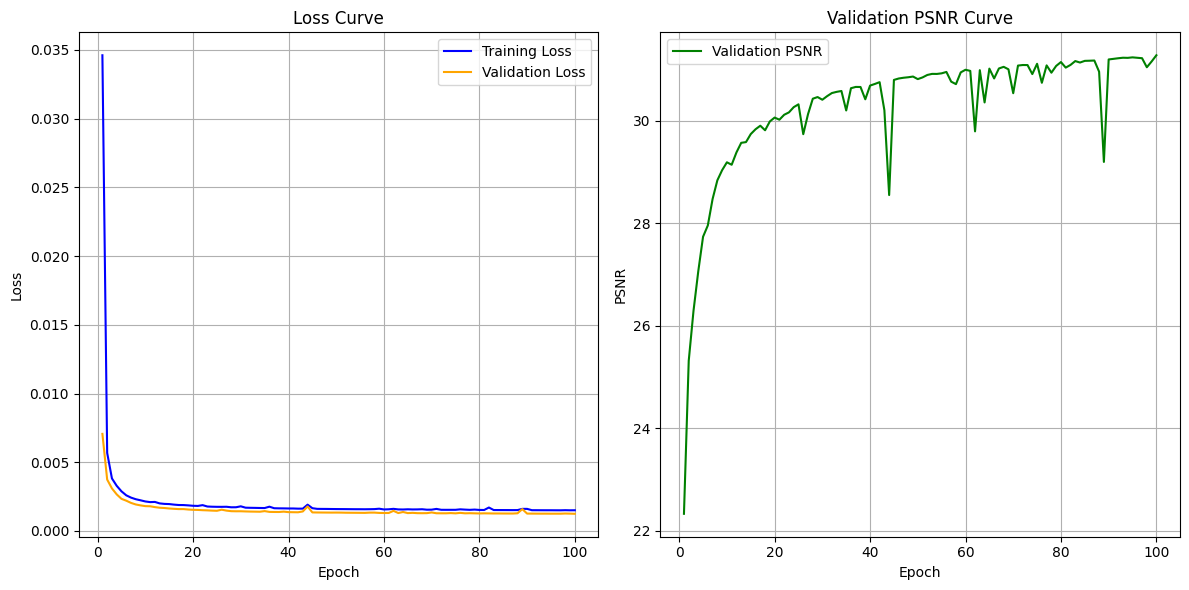

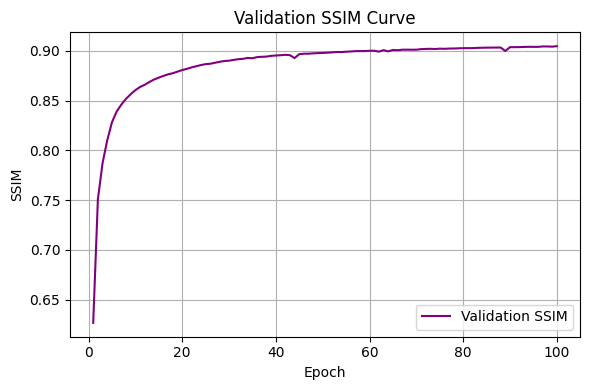

Time taken to train SRCNN after hyperparameter tuning: 551.47 minutes


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nTraining SRCNN after hyperparameter tuning...")
start_time = time.time()
srcnn = train(SRCNN(), train_loader, val_loader, epochs=100)
end_time = time.time()

    # print time taken to train in minutes 
print(f"Time taken to train SRCNN after hyperparameter tuning: {(end_time - start_time) / 60:.2f} minutes")

#### The increase of the number of filters increased the training time substantially.

In [27]:
torch.save(srcnn.state_dict(), "srcnnx2ht.pth")

# Inference 

In [3]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=9, padding=4),  # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=1),           # Increased filters
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
model = SRCNN()
model.load_state_dict(torch.load("SRCNNx2Hyperparameter Tuning/srcnnx2ht.pth"))
model.eval()

SRCNN(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [30]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx2htlr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx2htsr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx2hthr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 32.46 dB
SSIM: 0.9381
Example 2
PSNR: 25.47 dB
SSIM: 0.8781
Example 3
PSNR: 29.82 dB
SSIM: 0.9038
Example 4
PSNR: 27.30 dB
SSIM: 0.8768


### Comparision Images between Models

In [ ]:
# This is run only once
from PIL import Image
import os

def center_crop_images(dataset_path):
    # List all image files in the dataset
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Initialize variables to store the minimum width and height
    min_width = float('inf')
    min_height = float('inf')
    
    # Find the smallest image dimensions
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
    
    # Center crop all images to the size of the smallest image
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            # Calculate the cropping box (center crop)
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height
            
            # Crop and save the image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(os.path.join(dataset_path, f"cropped_{image_file}"))

# Crops all images in the dataset and saving them, original images (not cropped) were deleted manually from the foldeer by me
dataset_path = "./comparison_images"
center_crop_images(dataset_path)

In [8]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)


In [9]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx2htlr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx2htsr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx2hthr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 37.79 dB
SSIM: 0.9650
Example 2
PSNR: 38.19 dB
SSIM: 0.9727
Example 3
PSNR: 35.78 dB
SSIM: 0.8369
Example 4
PSNR: 38.42 dB
SSIM: 0.9498
